In [1]:
import sys

import clip
import gradio as gr
import hydra
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import train
import yaml
from dalle2_pytorch import DiffusionPriorNetwork
from omegaconf import DictConfig, OmegaConf
from PIL import Image
from torchvision import transforms
from tqdm import tqdm
from tqdm.auto import tqdm

sys.path.append("./stylegan3")
import dnnlib
import legacy
from clip2latent import train_utils
from clip2latent.latent_prior import LatentPrior
from clip2latent.train_utils import (compute_val, denormalise_data, make_grid,
                                     make_image_val_data, make_text_val_data)

checkpoint = "best.ckpt"
device = "cuda:0"
cfg_file = "best.yaml"
cfg = OmegaConf.load(cfg_file)

G, clip_model, trainer = train.load_models(cfg, device)

trainer.load_state_dict(torch.load(checkpoint, map_location="cpu")["state_dict"], strict=False)
diffusion_prior = trainer.diffusion_prior

/home/jpinkney/miniconda3/envs/clip2latent/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import einops

In [70]:
base = "a photo of a "
examples = {
    "smile": ("happy person smiling", "person with a neutral expression", slice(4, 5)),
    "hair": ("person with large curly hair", "person with straight hair", slice(4,7)),
    "age": ("very old person in their eighties", "a young child", slice(3,10)),
    "glasses": ("person wearing glasses", "person with no glasses", slice(1,3)), 
    "makeup": ("woman wearing makeup lipstick eye shadow blusher", "woman with natural skin", slice(6,10)), 
    "beard": ("man with a beard", "clean shaven man", slice(5,10)),
    "null": ("","",slice(0,0)),
}
chosen = "hair"
pos_sample = base + examples[chosen][0]
neg_sample = base + examples[chosen][1]
select_layers = examples[chosen][2]
n_samples = 1000



In [4]:
def find_direction(pos_prompt, neg_prompt, n_samples=1000):
    pos_features = clip_model.embed_text(pos_prompt)
    neg_features = clip_model.embed_text(neg_prompt)

    all_features = torch.cat((pos_features.tile(n_samples, 1), neg_features.tile(n_samples, 1)), dim=0)

    all_pred = diffusion_prior.sample(all_features, cond_scale=1)
    pos = all_pred[:n_samples]
    neg = all_pred[n_samples:]
    direction = pos.mean(dim=0) - neg.mean(dim=0)
    return direction[0]

In [5]:
directions = {}
for name, params in examples.items():
    if name == "null":
        continue
    directions[name] = find_direction(params[0], params[1])

directions["null"] = torch.zeros_like(directions["smile"])

sampling loop time step: 100%|███████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.98it/s]


In [71]:
import torchvision
scale = 1
n_examples = 16

with torch.no_grad():
    torch.manual_seed(0)
    z = torch.randn(n_examples, 512, device=device)
    w = G.mapping(z, c=None, truncation_psi=0.7)
    
out = []

for name, d in tqdm(directions.items()):
    select_layers = examples[name][2]
    with torch.no_grad():
        mod_w = w.clone()
        edit = scale*d
        mod_w[:, select_layers, :] = mod_w[:, select_layers, :]+edit # as in interface gan

        out.append(G.synthesis(mod_w, noise_mode="const"))
out.insert(0, out.pop()) # move null to start

100%|██████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.71it/s]


In [77]:

chosen = [int(x) for x in (3,6,7,12)]
first = torch.cat([x[chosen].unsqueeze(0) for x in out], dim=0)
first = einops.rearrange(first, 'dir person c h w -> c (person h) (dir w)')
grid = first.clamp(-1,1)*0.5 + 0.5
grid = Image.fromarray((255*grid).to(torch.uint8).permute(1,2,0).detach().cpu().numpy())
display_grid = grid.reduce(4)

In [78]:
print(directions.keys())

dict_keys(['smile', 'hair', 'age', 'glasses', 'makeup', 'beard', 'null'])


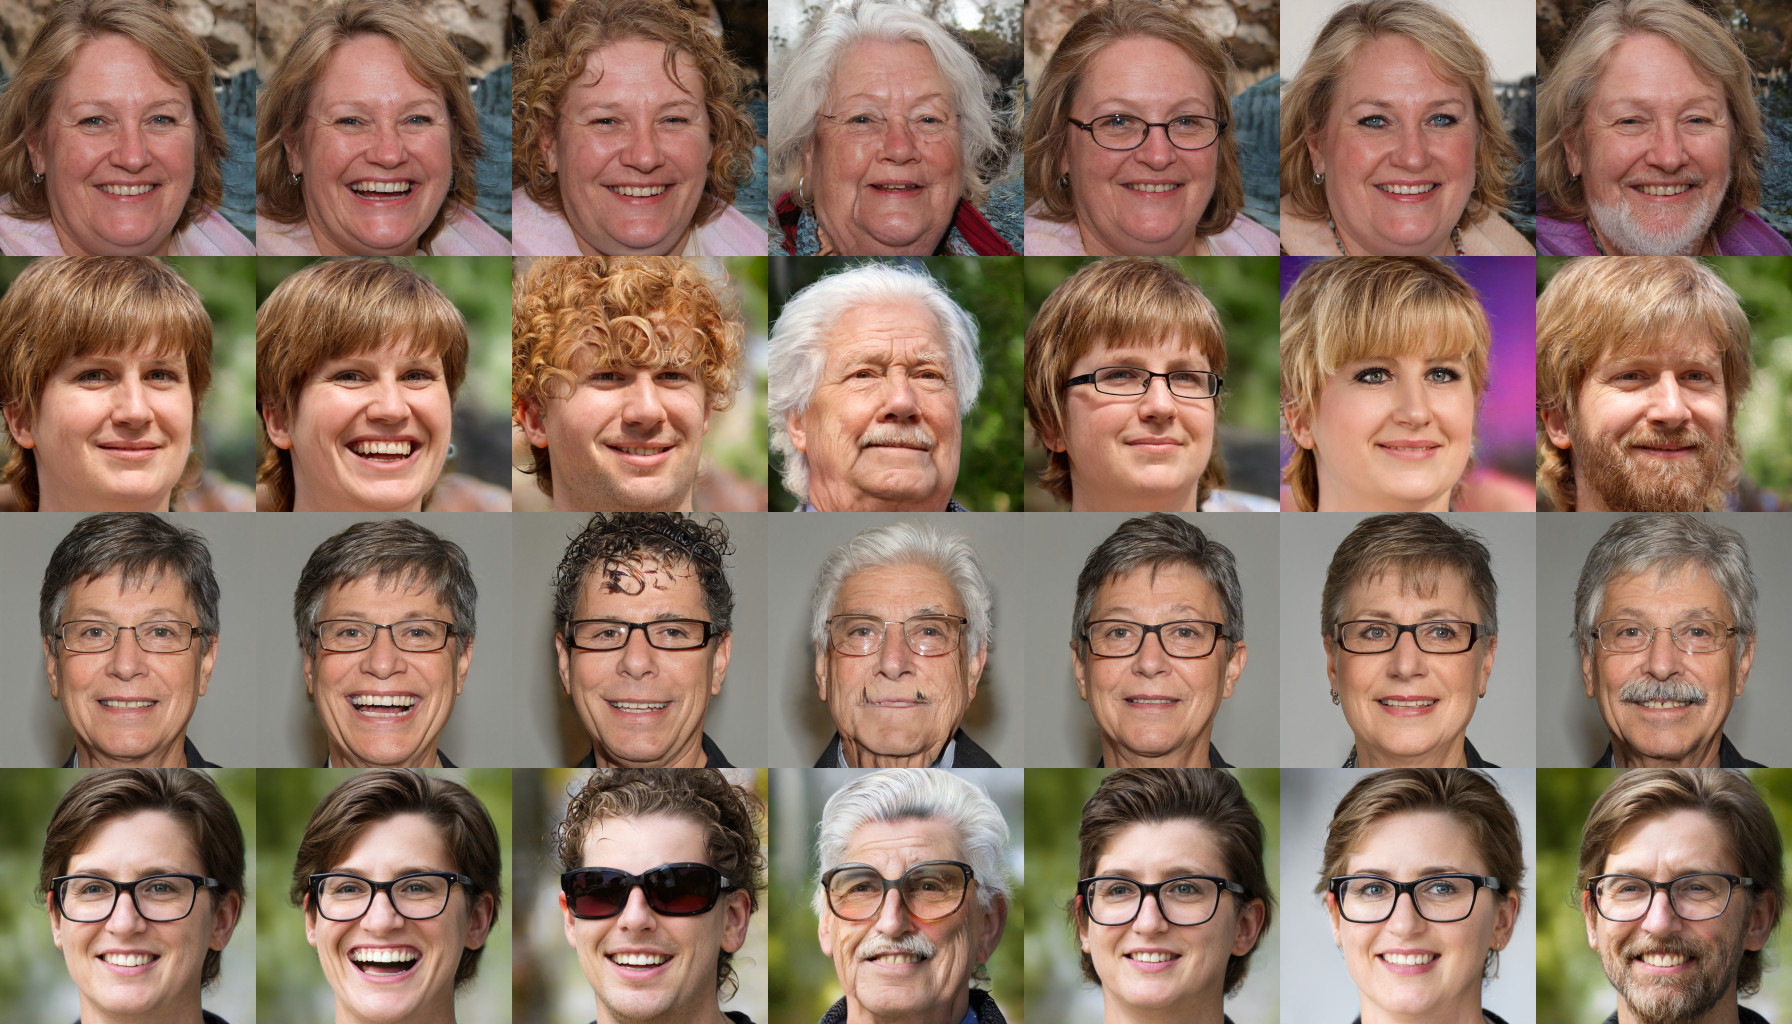

In [79]:

display_grid

In [80]:
grid.save("edit_dir.jpg")

In [76]:
grid.size

(1792, 1024)